In [1]:
%matplotlib inline

In [2]:
# Uses the exact data set and permutation from the psMNIST task in
# Towards Non-saturating Recurrent Units for Modelling Long-term Dependencies
# https://github.com/apsarath/NRU/

import os
import sys

nru_path = os.path.abspath("../nru/nru_project")
sys.path.append(nru_path)

In [3]:
import numpy as np

from utils.utils import create_config
from train import get_data_iterator

try:
    cwd = os.getcwd()
    os.chdir(nru_path)  # needed to load parent config/default.yaml
    os.environ["PROJ_SAVEDIR"] = "/tmp/"  # this shouldn't do anything
    config = create_config(os.path.join(nru_path, "config/nru.yaml"))
    
finally:
    os.chdir(cwd)

In [4]:
padded_length = 785
batch_size = 100

mask_check = np.zeros((padded_length, batch_size))
mask_check[-1, :] = 1

from collections import defaultdict
X = defaultdict(list)
Y = defaultdict(list)

gen = get_data_iterator(config)  # uses a fixed data seed
for tag in ("train", "valid", "test"):
    while True:
        data = gen.next(tag)
        if data is None:
            break

        assert data['x'].shape == (padded_length, batch_size, 1)
        assert data['y'].shape == data['mask'].shape == (padded_length, batch_size)
        assert np.all(data['mask'] == mask_check)
        
        assert np.all(data['x'][-1, :, :] == 0)
        X[tag].extend(data['x'][:-1, :, :].transpose(1, 0, 2))
        
        assert np.all(data['y'][:-1, :] == 0)
        Y[tag].extend(data['y'][-1, :])

X_train = np.asarray(X["train"])
X_valid = np.asarray(X["valid"])
X_test = np.asarray(X["test"])

Y_train = np.asarray(Y["train"])
Y_valid = np.asarray(Y["valid"])
Y_test = np.asarray(Y["test"])

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(50000, 784, 1) (50000,)
(10000, 784, 1) (10000,)
(10000, 784, 1) (10000,)


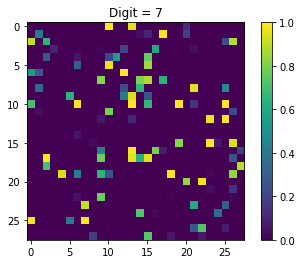

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplot(111)
plt.title("Digit = %d" % Y_train[1])
plt.imshow(X_train[1].reshape(28, 28))
plt.colorbar()
plt.show()

In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.layers.core import Dense
from keras.layers.recurrent import RNN
from keras.models import Sequential, Model
from keras.initializers import Constant
from keras.utils import multi_gpu_model, to_categorical

Using TensorFlow backend.


In [7]:
seed = 0  # to help with reproducibility

from tensorflow import set_random_seed
set_random_seed(seed=seed)
np.random.seed(seed=seed)

LMU parameters

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
rnn_1 (RNN)                  (None, 212)               165689    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2130      
=================================================================
Total params: 167,819
Trainable params: 102,027
Non-trainable params: 65,792
_________________________________________________________________
```

In [8]:
n_pixels = padded_length - 1
assert n_pixels == 28**2

In [10]:
from phased_lstm_keras.PhasedLSTM import PhasedLSTM as PLSTM

In [43]:
import time

model = Sequential()
model.add(PLSTM(200, input_shape=(n_pixels, 1), 
                implementation=0,
               alpha=0.0001)
         )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',
                        metrics=['accuracy'])
model.summary()

epochs = 10
fname = "../models/psMNIST-plstm.hdf5"

callbacks = [
    #CSVLogger('log-psmnist-plstm-270719.csv', append=True, separator=';'),
    EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5),
    ModelCheckpoint(filepath=fname, monitor='val_loss', verbose=1, save_best_only=True),
]

t = time.time()

n_samples = None
result = model.fit(
    X_train[:n_samples],
    to_categorical(Y_train[:n_samples]),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid[:n_samples], to_categorical(Y_valid)[:n_samples]),
    callbacks=callbacks,
)

print("Took {:.2f} min".format((time.time() - t) / 60))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
phased_lstm_28 (PhasedLSTM)  (None, 200)               162200    
_________________________________________________________________
dense_28 (Dense)             (None, 10)                2010      
Total params: 164,210
Trainable params: 164,210
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 971s 19ms/step - loss: 1.0911 - acc: 0.6018 - val_loss: 0.5815 - val_acc: 0.8170

Epoch 00001: val_loss improved from inf to 0.58153, saving model to ../models/psMNIST-plstm.hdf5
Epoch 2/10
50000/50000 [==============================] - 964s 19ms/step - loss: 0.5034 - acc: 0.8387 - val_loss: 0.4663 - val_acc: 0.8496

Epoch 00002: val_loss improved from 0.58153 to 0.46631, saving model to ../models/psMNIST-plstm.hdf5
Epoc

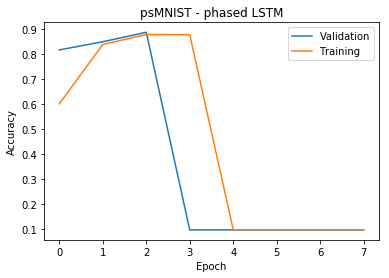

In [44]:
plt.figure()
plt.plot(result.history['val_acc'], label="Validation")
plt.plot(result.history['acc'], label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("psMNIST - phased LSTM")
plt.show()

In [ ]:
saved_epoch = np.argmin(result.history['val_loss'])
result.history['val_acc'][saved_epoch]

In [45]:
model.load_weights(fname)  # load best weights
model.evaluate(X_test, to_categorical(Y_test))

10000/10000 [==============================] - 78s 8ms/step


[0.331656537681818, 0.8961]